In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.layers import *
from tensorflow.keras.activations import gelu
from tensorflow.keras.utils import plot_model
from utils.plot_utils import plot_iou_trainId, plot_iou_catId, label_to_rgb, display, create_mask
from utils.data_utils import get_labels, parse_record, get_dataset_from_tfrecord
from utils.train_utils import weighted_cross_entropy_loss
from data_loaders import CityscapesLoader
from setr import ClassToken, AddPositionEmbs, MultiHeadSelfAttention, TransformerBlock

K.clear_session()
# physical_devices = tf.config.experimental.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# tf.config.experimental.set_memory_growth(physical_devices[1], True)

def enable_amp():
    mixed_precision.set_global_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
# print(physical_devices,"\n")
# enable_amp() 

# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Tensorflow version:  2.5.0


In [2]:
# echo "deb [signed-by=/usr/share/keyrings/cloud.google.gpg] https://packages.cloud.google.com/apt cloud-sdk main" | 
#    sudo tee -a /etc/apt/sources.list.d/google-cloud-sdk.list

# apt-get install apt-transport-https ca-certificates gnupg

# curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | 
# sudo apt-key --keyring /usr/share/keyrings/cloud.google.gpg add -

# sudo apt-get update && sudo apt-get install google-cloud-sdk

# gcloud init --console-only

# gsutil cp gs://cl_datasets_01/cityscapes/records/trainIds_train.record /mnt/vol_b/records/trainIds_train.record 
# gsutil cp gs://cl_datasets_01/cityscapes/records/trainIds_val.record /mnt/vol_b/records/trainIds_val.record 
# gsutil cp gs://cl_datasets_01/cityscapes/records/ /mnt/vol_b/weights/

In [3]:
n_classes = 20
img_size = 768
patch_size = 16

BATCH_SIZE = 8
BUFFER_SIZE = 512

labels = get_labels()
trainid2label = { label.trainId : label for label in labels }
catid2label = { label.categoryId : label for label in labels }

pipeline = CityscapesLoader(
    img_height=img_size, 
    img_width=img_size, 
    n_classes=n_classes
)

In [4]:
train_tfrecord_dir = "records/trainIds_train.record"
valid_tfrecord_dir = "records/trainIds_val.record"

TRAIN_LENGTH = 2975
VALID_LENGTH = 500

In [5]:
EPOCHS = 110 
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE 
VALIDATION_STEPS = VALID_LENGTH // BATCH_SIZE 
DECAY_STEPS = (STEPS_PER_EPOCH * EPOCHS) # // ACCUM_STEPS
print("Decay steps: {}".format(DECAY_STEPS))

Decay steps: 40810


In [6]:
train_ds = get_dataset_from_tfrecord(train_tfrecord_dir)
valid_ds = get_dataset_from_tfrecord(valid_tfrecord_dir)

In [7]:
train = train_ds.map(pipeline.load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
valid = valid_ds.map(pipeline.load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = valid_ds.map(pipeline.load_image_eval)

train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

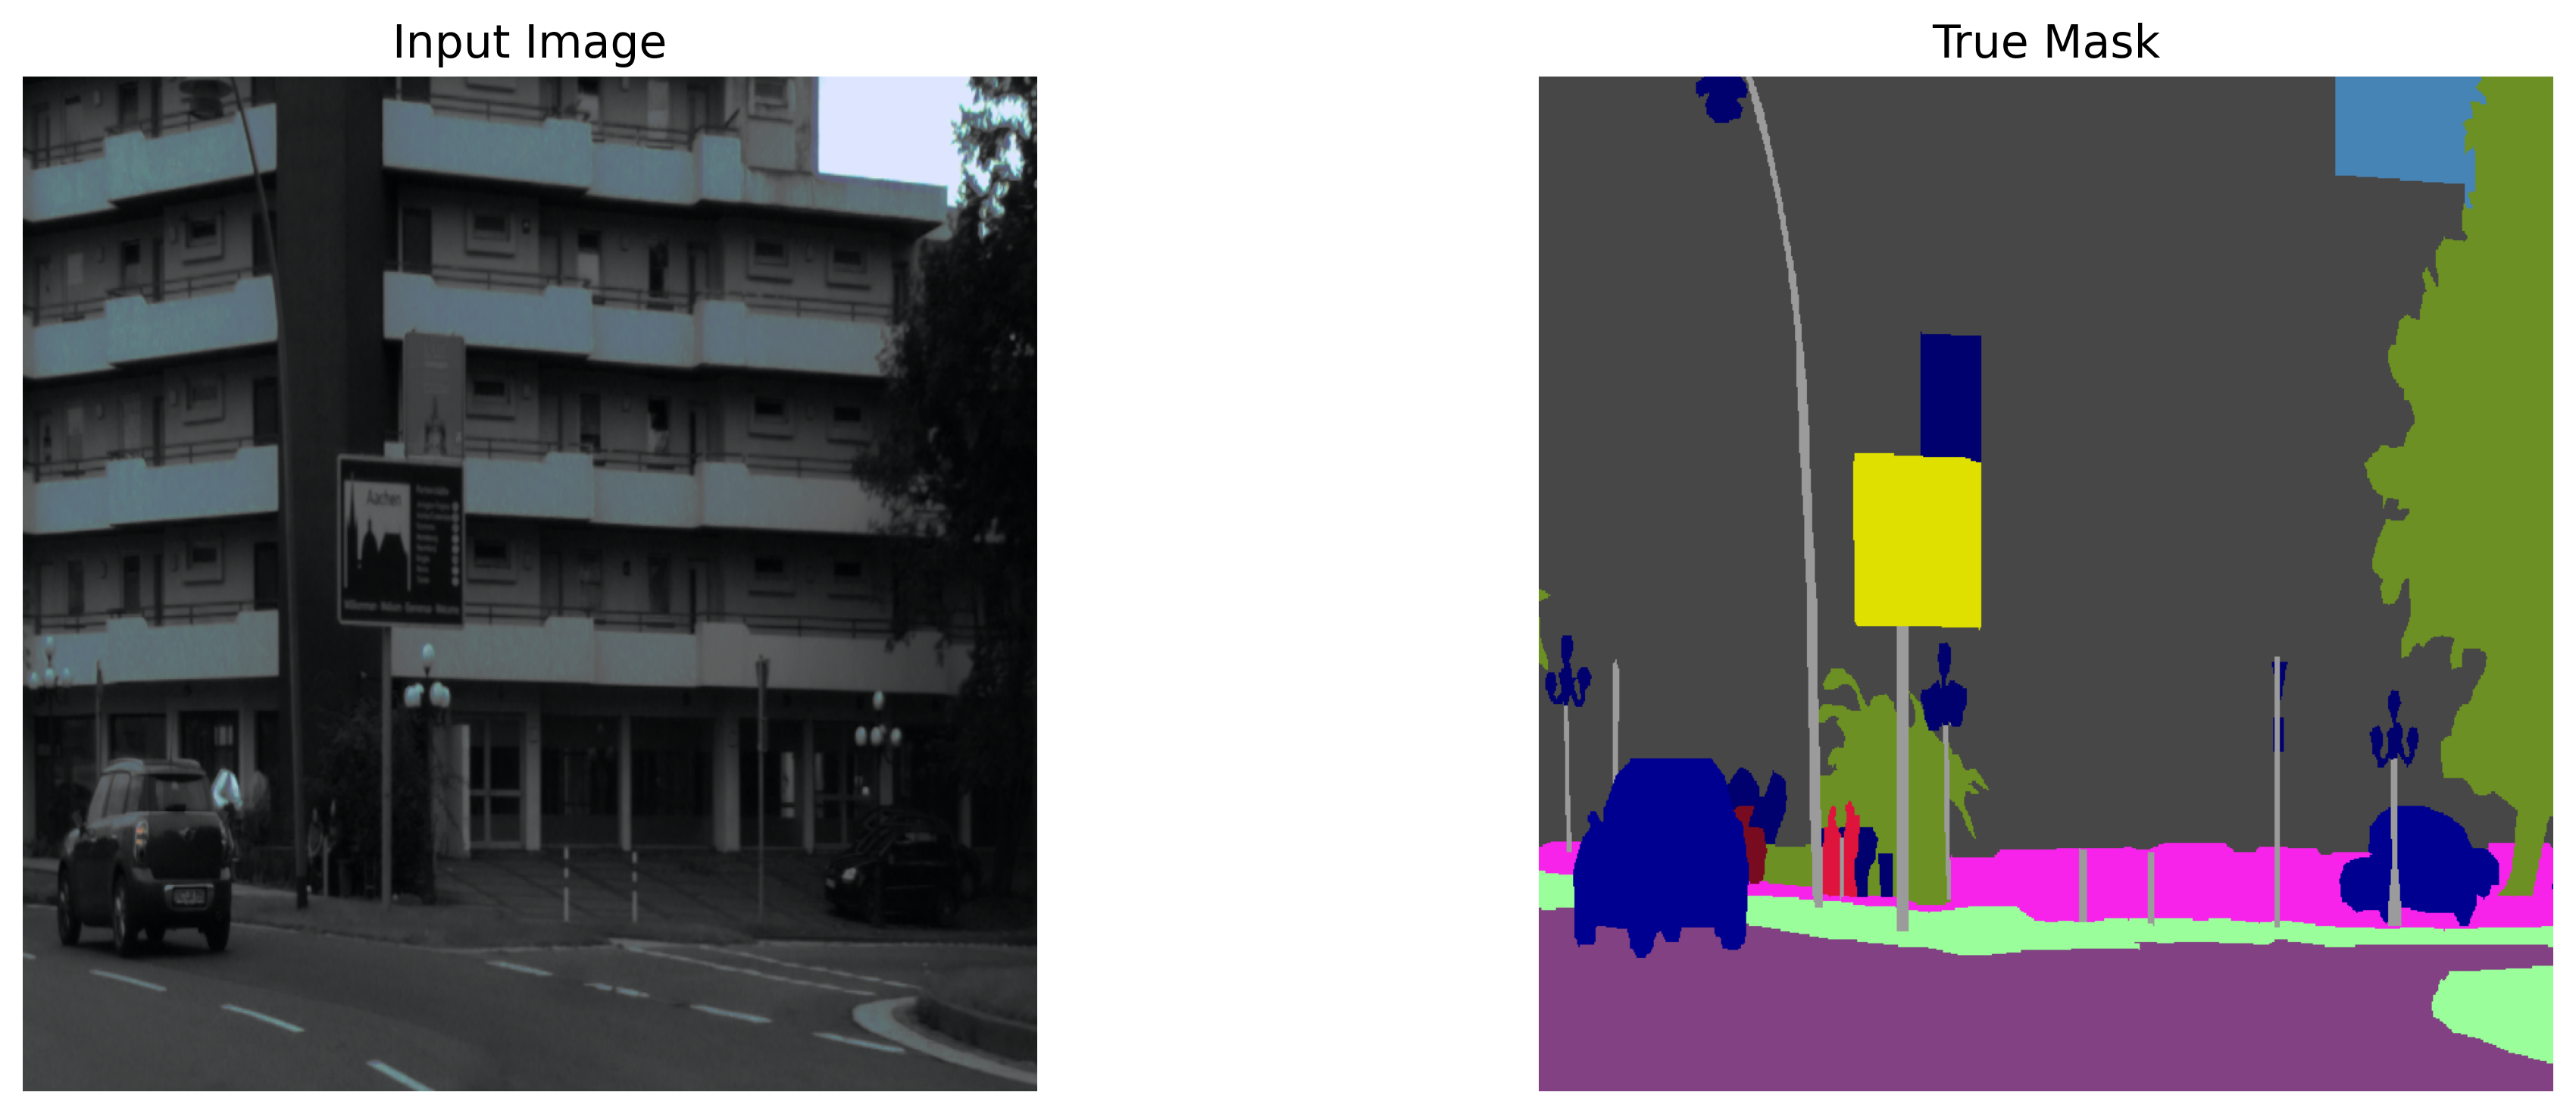

In [8]:
for image, mask in train.take(1): 
    sample_image, sample_mask = image, mask

sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())
display([sample_image, sample_mask])

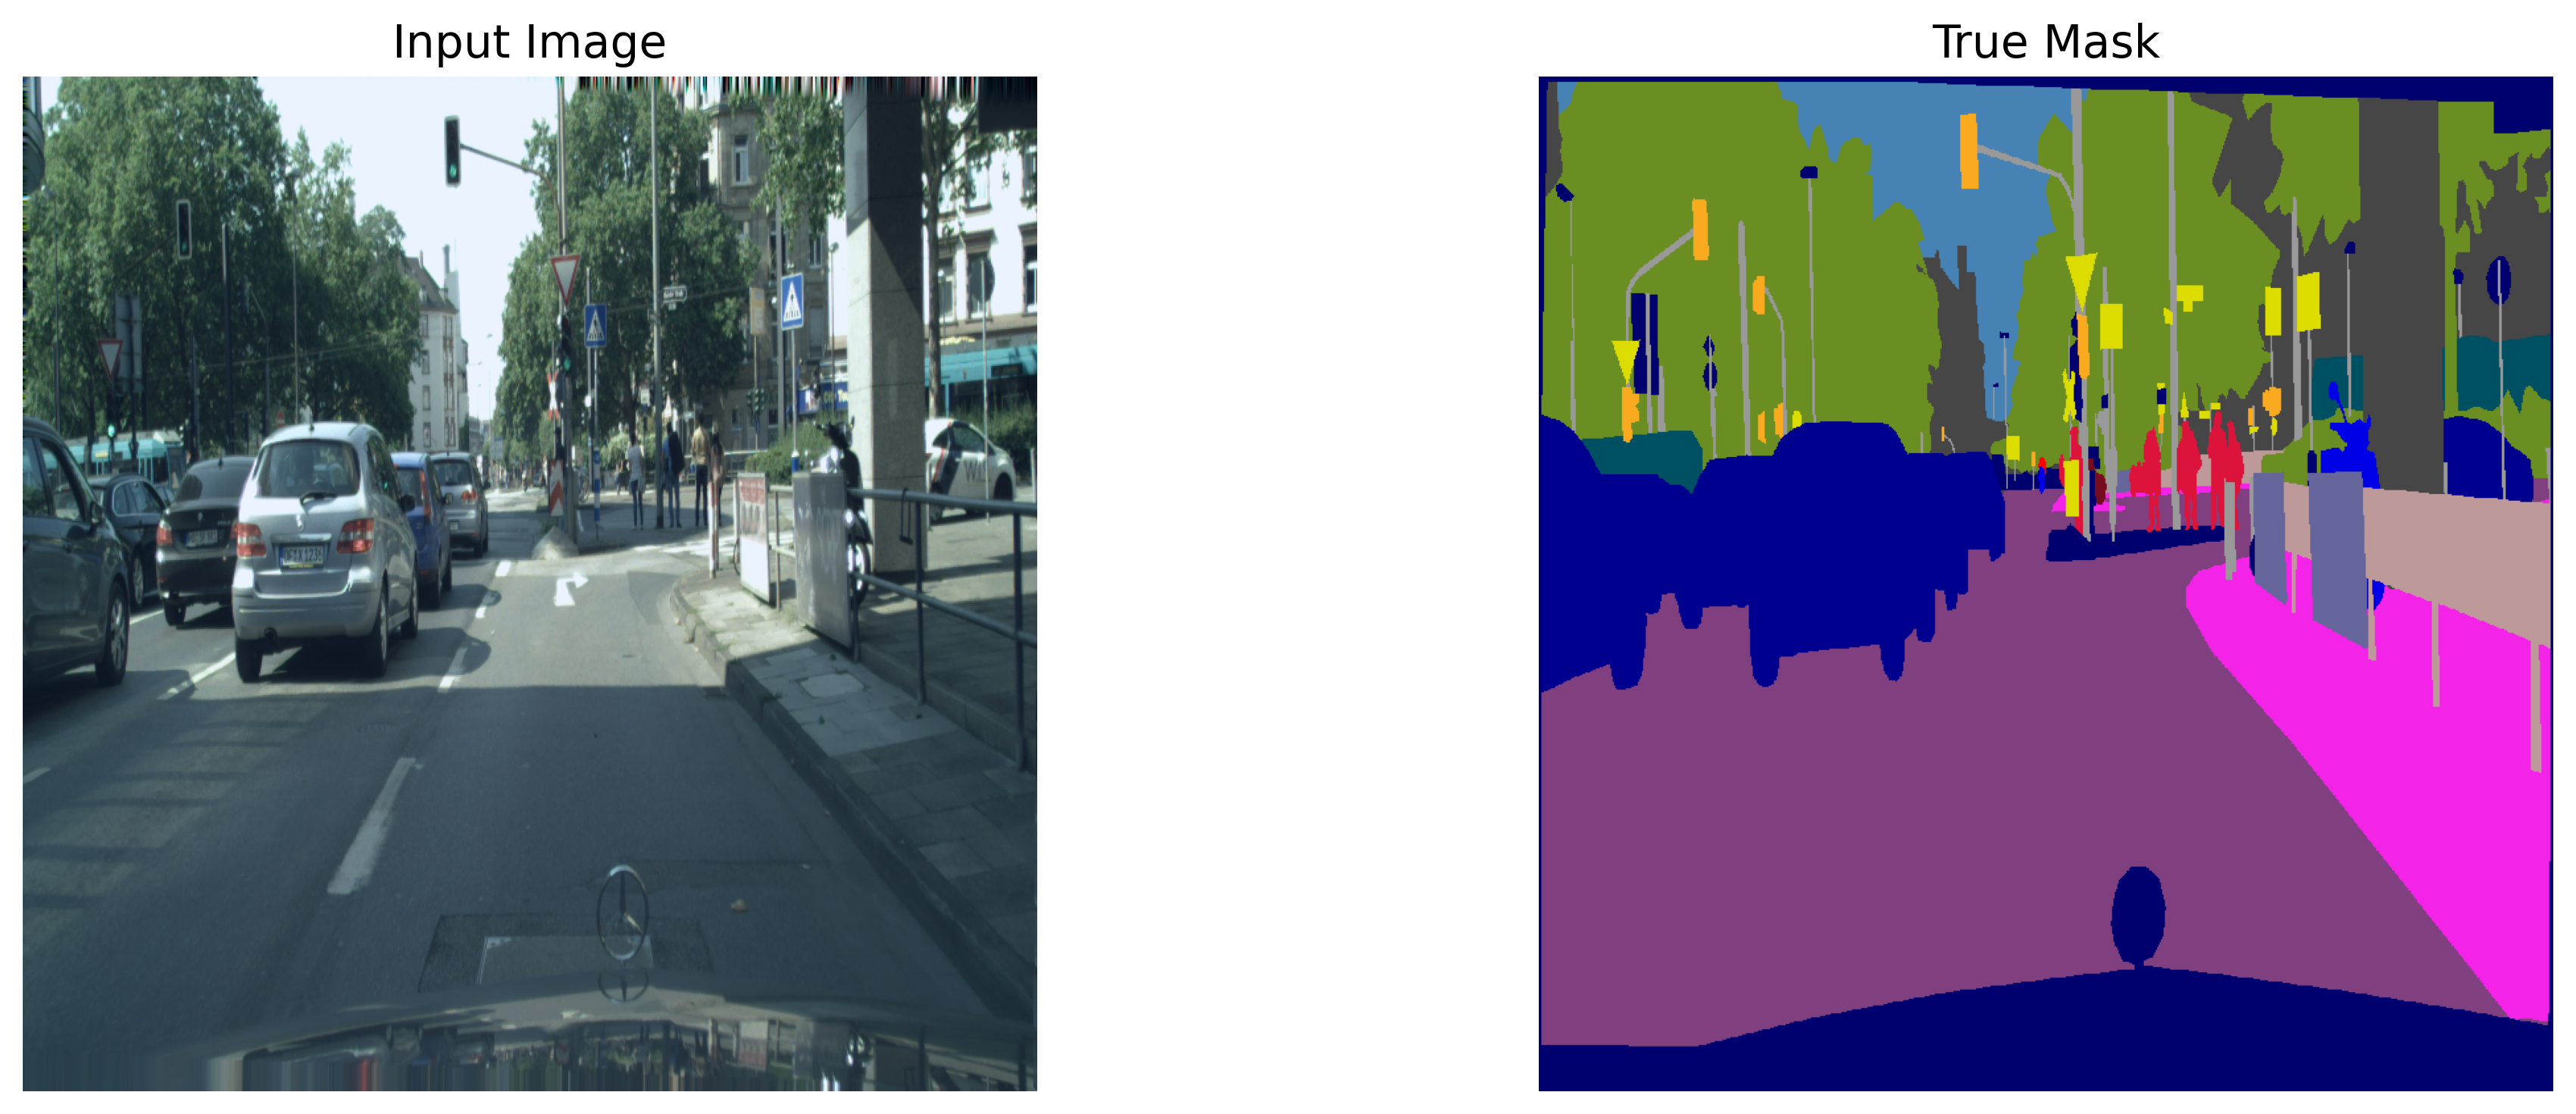

In [9]:
for image, mask in valid.take(27): 
    sample_image, sample_mask = image, mask

sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())
display([sample_image, sample_mask])

In [10]:
def aux_head(x, n, image_size, hidden_size, num_classes):
    y_aux = Lambda(lambda v: v[:, 1:], name="Aux_{}_ExtractToken".format(n))(x)
    y_aux = LayerNormalization(epsilon=1e-6, name="Aux_{}_norm".format(n))(y_aux)
    y_aux = Reshape(target_shape=(int(image_size//16), int(image_size//16), hidden_size))(y_aux)
    
    y_aux = Conv2D(hidden_size, kernel_size=(3,3), strides=(1,1), padding='same', 
                   name="Aux_{}_conv_1".format(n))(y_aux)
    y_aux = BatchNormalization(name="Aux_{}_bn".format(n))(y_aux)
    y_aux = Activation("relu", name="Aux_{}_relu".format(n))(y_aux)
    y_aux = UpSampling2D(size=(8,8), interpolation='bilinear', name="Aux_{}_upsample_1".format(n))(y_aux)
    y_aux = Conv2D(256, kernel_size=(1,1), strides=(1,1), padding='same', name="Aux_{}_conv_2".format(n))(y_aux)
    y_aux = UpSampling2D(size=(8,8), interpolation='bilinear', name="Aux_{}_upsample_2".format(n))(y_aux)
    
    y_aux = Conv2D(num_classes, kernel_size=(1,1), strides=(1,1), padding='same', 
                     dtype='float32', name="Aux_{}_output".format(n))(y_aux)
    
    return y_aux


def get_aux_heads(y_list, image_size, hidden_size, num_classes, aux_layers):
    
    y_aux_list = []
    for i in range(0, len(y_list)):
        y_aux = aux_head(y_list[i], aux_layers[i], image_size, hidden_size, num_classes)
        y_aux_list.append(y_aux)
        
    return list(y_aux_list)


def get_decode_head(y, image_size, hidden_size, num_classes):
    
    y = Reshape(target_shape=(int(image_size//16), int(image_size//16), hidden_size))(y)
    
    y = UpSampling2D(size=(2,2), interpolation='bilinear', name="Decode_upsample_1")(y)
    y = Conv2D(hidden_size, kernel_size=(3,3), strides=(1,1), padding='same', name="Decode_conv_1")(y)
    y = BatchNormalization(name="Decode_bn_1")(y)
    y = Activation("relu", name="Decode_relu_1")(y)

    y = UpSampling2D(size=(2,2), interpolation='bilinear', name="Decode_upsample_2")(y)
    y = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', name="Decode_conv_2")(y)
    y = BatchNormalization(name="Decode_bn_2")(y)
    y = Activation("relu", name="Decode_relu_2")(y)

    y = UpSampling2D(size=(2,2), interpolation='bilinear', name="Decode_upsample_3")(y)
    y = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', name="Decode_conv_3")(y)
    y = BatchNormalization(name="Decode_bn_3")(y)
    y = Activation("relu", name="Decode_relu_3")(y)

    y = UpSampling2D(size=(2,2), interpolation='bilinear', name="Decode_upsample_4")(y)
    y = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', name="Decode_conv_4")(y)
    y = BatchNormalization(name="Decode_bn_4")(y)
    y = Activation("relu", name="Decode_relu_4")(y)
    
    y = Conv2D(num_classes, kernel_size=(1,1), strides=(1,1), padding='same', 
        dtype='float32', name="Decode_output")(y)
    
    return y

In [11]:
def SETR_PUP(
    image_size, 
    patch_size, 
    num_layers, 
    num_classes, 
    hidden_size, 
    aux_layers,
    num_heads, 
    name, 
    mlp_dim, 
    dropout=0.1
):
    """Build a ViT model.

    Args:
        image_size: The size of input images.
        patch_size: The size of each patch (must fit evenly in image_size)
        num_layers: The number of transformer layers to use.
        hidden_size: The number of filters to use
        num_heads: The number of transformer heads
        mlp_dim: The number of dimensions for the MLP output in the transformers.
        dropout_rate: fraction of the units to drop for dense layers.
    """
    assert image_size % patch_size == 0, "image_size must be a multiple of patch_size"
    
    x = Input(shape=(image_size, image_size, 3))
    y = Conv2D(
        filters=hidden_size, 
        kernel_size=patch_size, 
        strides=patch_size, 
        padding="valid", 
        name="embedding"
    )(x)
    y = Reshape((y.shape[1] * y.shape[2], hidden_size))(y)
    y = ClassToken(name="class_token")(y)
    y = AddPositionEmbs(name="Transformer/posembed_input")(y)
    
    y_list = []
    for n in range(num_layers):
        y, _ = TransformerBlock(
            num_heads=num_heads, 
            mlp_dim=mlp_dim, 
            dropout=dropout, 
            name=f"Transformer/encoderblock_{n}"
        )(y)
        
        if aux_layers is not None:
            if n in aux_layers:
                y_list.append(y)
            
    if aux_layers is not None:
        y_aux_list = get_aux_heads(y_list, image_size, hidden_size, num_classes, aux_layers)
            
    y = Lambda(lambda v: v[:, 1:], name="ExtractToken")(y)
    y = LayerNormalization(epsilon=1e-6, name="Transformer/encoder_norm_decode")(y)
    
    y = get_decode_head(y, image_size, hidden_size, num_classes)

    if aux_layers is not None:
        out_heads = [y] + y_aux_list
    else:
        out_heads = [y]
    
    return tf.keras.models.Model(inputs=x, outputs=out_heads, name=name)

In [12]:
CONFIG_B = {
    "dropout": 0.1,
    "mlp_dim": 3072,
    "num_heads": 12,
    "num_layers": 12,
    "hidden_size": 768,
    "aux_layers": None,
    "name": "SETR-B_16",
    "pretrained": "weights/vit_b16_imagenet21k.h5"
}

CONFIG_L = {
    "dropout": 0.1,
    "mlp_dim": 4096,
    "num_heads": 16,
    "num_layers": 24,
    "hidden_size": 1024,
    "aux_layers": [9, 14, 19, 23],
    "name": "SETR-L_16",
    "pretrained": "weights/vit_l16_imagenet21k.h5"
}

config = CONFIG_B

In [ ]:
K.clear_session()

In [13]:
def get_model():

    # with strategy.scope():

    learning_rate_fn = PolynomialDecay(
        initial_learning_rate = 5e-3,
        decay_steps = DECAY_STEPS,
        end_learning_rate = 5e-6,
        power = 0.9
    )

    model = SETR_PUP(
        image_size = img_size,
        patch_size = patch_size,
        num_classes = n_classes,
        num_layers = config["num_layers"],
        hidden_size = config["hidden_size"],
        aux_layers = config["aux_layers"],
        num_heads = config["num_heads"],
        name = config["name"],
        mlp_dim = config["mlp_dim"],
        dropout = 0.1,
    )
    model.load_weights(config["pretrained"], by_name=True)

    model.compile(
        optimizer = SGD(learning_rate=learning_rate_fn, momentum=0.9, decay=0.0005),
        loss = weighted_cross_entropy_loss,
        metrics = ['accuracy', iou_coef]
        )
        
    return model


def show_predictions():        
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    display([sample_image, sample_mask, create_mask(pred_mask)])

        
def iou_coef(y_true, y_pred):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=n_classes)
    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_pred = tf.one_hot(tf.cast(y_pred, tf.int32), depth=n_classes)
    smooth = 1
    iou_total = 0
    for i in range(1, n_classes):
        intersection = tf.math.reduce_sum(y_true[:,:,:,i] * y_pred[:,:,:,i], axis=(1,2))
        union = tf.math.reduce_sum(y_true[:,:,:,i] + y_pred[:,:,:,i], axis=(1,2)) 
        iou = tf.math.reduce_mean(tf.math.divide_no_nan(2.*intersection+smooth, union+smooth), axis=0)
        iou_total += iou
    return iou_total/(n_classes-1)

In [14]:
model = get_model()

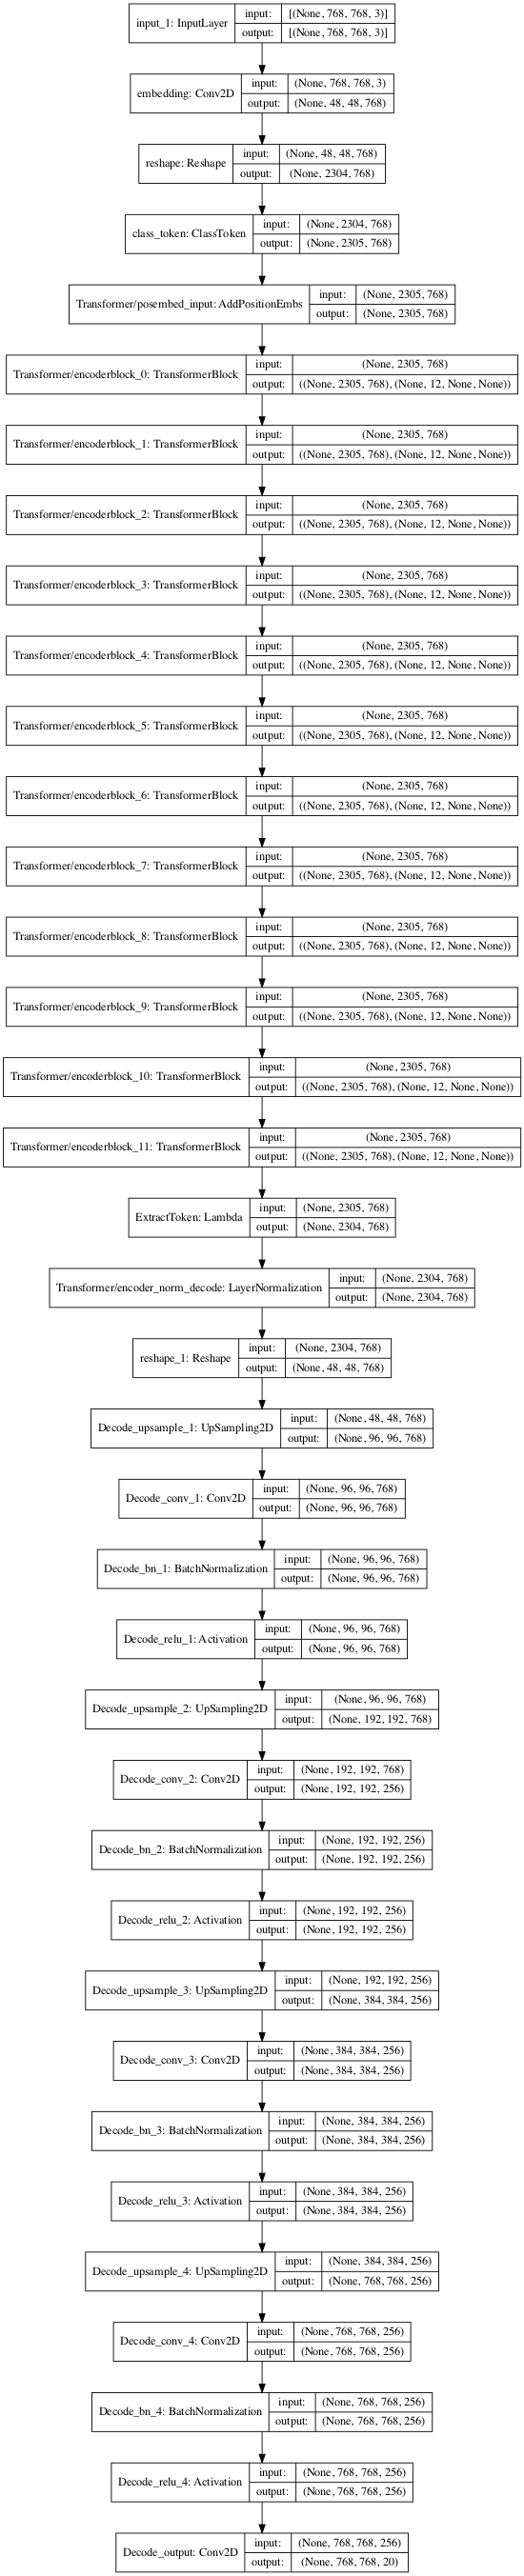

In [15]:
plot_model(model, show_shapes=True, dpi=64, expand_nested=True)

In [ ]:
MODEL_PATH = "weights/"+model.name+".h5"

In [ ]:
# model.load_weights(MODEL_PATH, by_name=True)

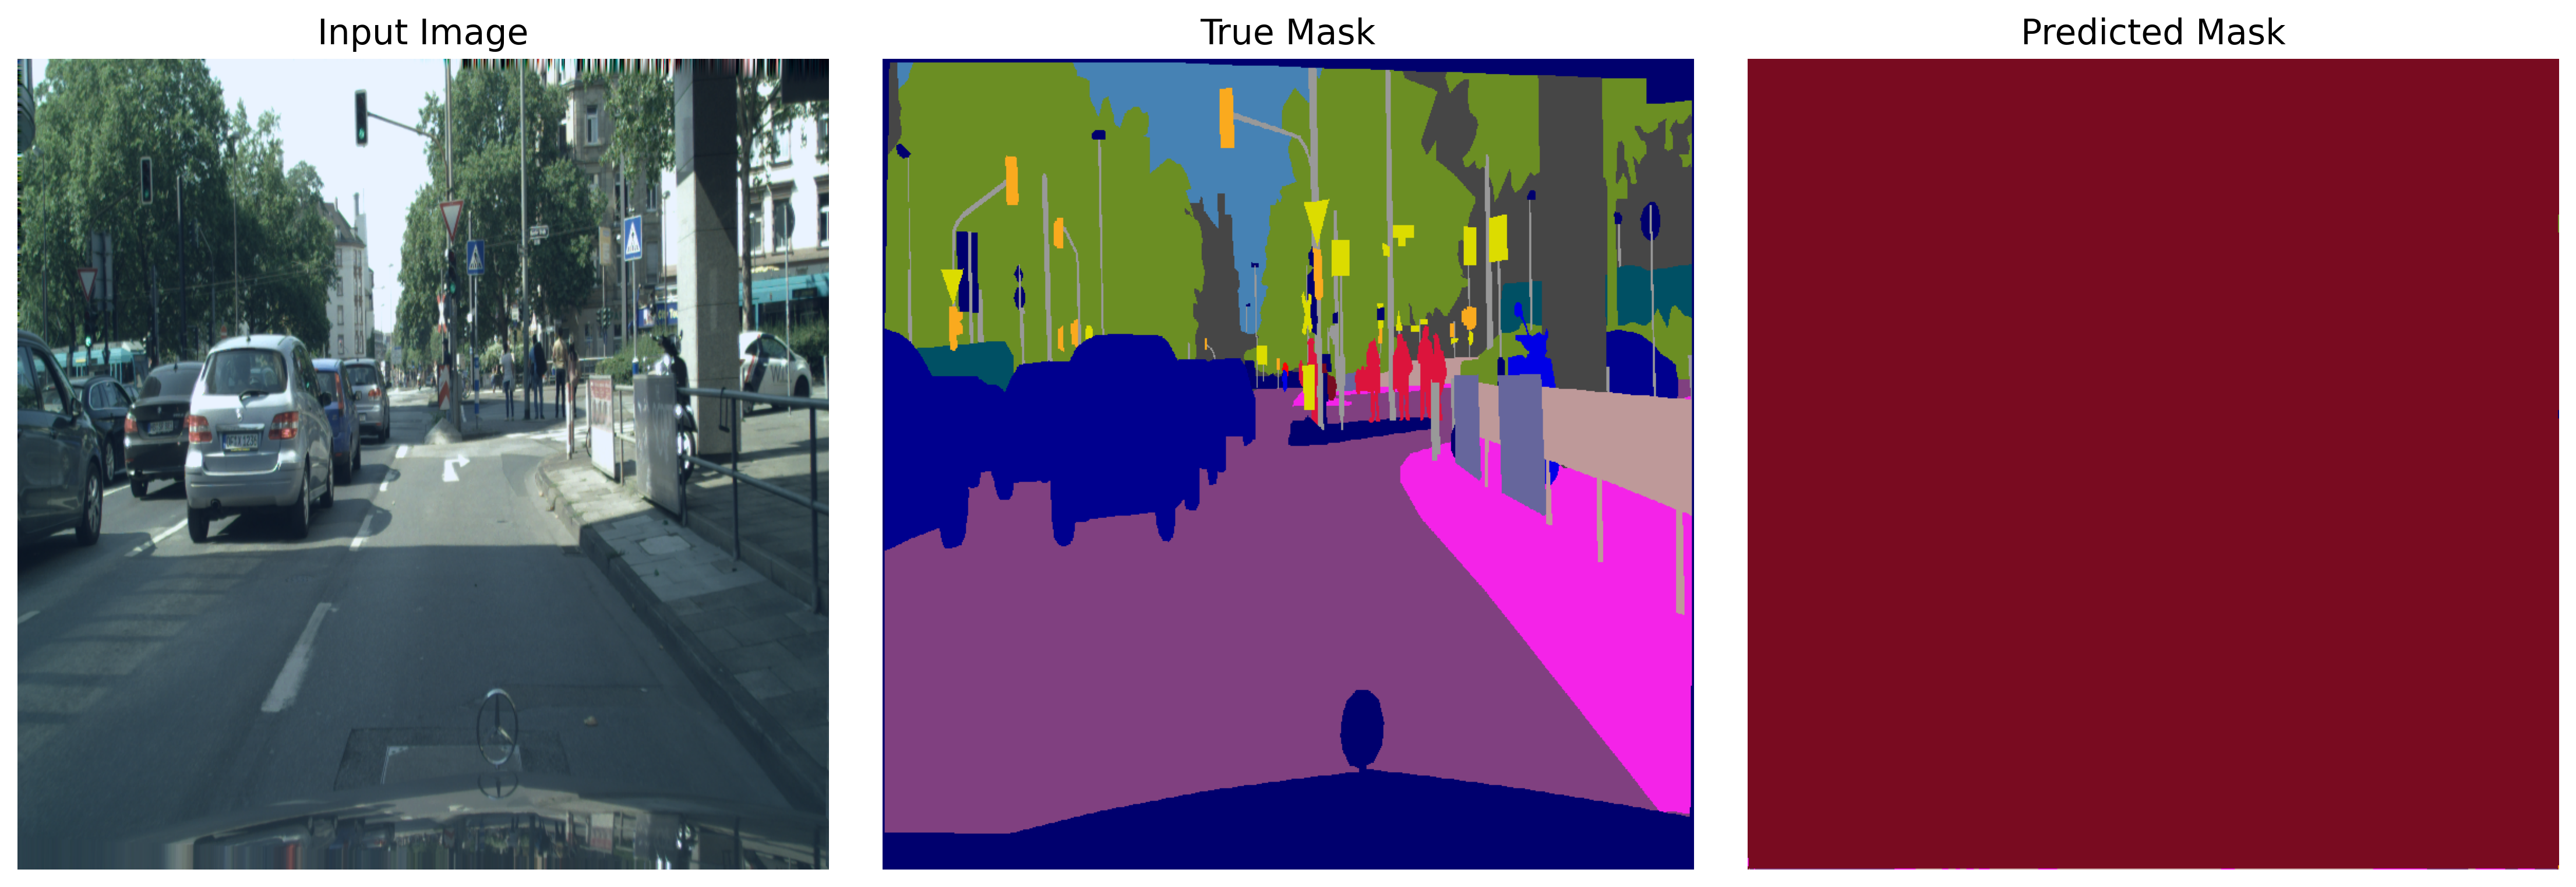

In [16]:
show_predictions()

In [17]:
model.summary()

Model: "SETR-B_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768, 768, 3)]     0         
_________________________________________________________________
embedding (Conv2D)           (None, 48, 48, 768)       590592    
_________________________________________________________________
reshape (Reshape)            (None, 2304, 768)         0         
_________________________________________________________________
class_token (ClassToken)     (None, 2305, 768)         768       
_________________________________________________________________
Transformer/posembed_input ( (None, 2305, 768)         1770240   
_________________________________________________________________
Transformer/encoderblock_0 ( ((None, 2305, 768), (None 7087872   
_________________________________________________________________
Transformer/encoderblock_1 ( ((None, 2305, 768), (None 70

In [ ]:
callbacks = [
    # EarlyStopping(monitor='val_iou_coef', mode='max', patience=40, verbose=2),
    # ReduceLROnPlateau(monitor='val_iou_coef', mode='max', patience=10, factor=0.5, min_lr=1e-5, verbose=2),
    ModelCheckpoint(MODEL_PATH, monitor='val_iou_coef', mode='max', 
                    verbose=2, save_best_only=True, save_weights_only=True)    
]

In [ ]:
results = model.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
results = model.history

In [ ]:
def plot_history(results, model):
         
    plt.figure(figsize=(15,7))
    plt.subplot(1,3,1)  

    plt.plot(results.history['loss'], 'r', label='Training loss')
    plt.plot(results.history['val_loss'], 'b', label='Validation loss')
    plt.title("Loss: "+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,2)
    plt.plot(results.history['accuracy'], 'r', label='Training accuracy')
    plt.plot(results.history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Accuracy: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,3)
    plt.plot(results.history['iou_coef'], 'r', label='IoU coefficient')
    plt.plot(results.history['val_iou_coef'], 'b', label='Validation IoU coefficient')
    plt.title('IoU Coefficient: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})
    
    if fine:
        plt.savefig("plots/"+model.name+"_learning_curves.png")
    else:
        plt.savefig("plots/"+model.name+"_learning_curves_coarse.png")
    plt.show()

In [ ]:
plot_history(results, model)